# [IUM] Predykcja czasu dostawy

## Autorzy
* Adamski Maciej
* Olga Krupa

## Zadanie


### Treść
Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Gdybysmy wiedzieli, ile taka dostawa dla danego zamówienia potrwa - moglibyśmy przekazać tę informację klientom.

### Problem biznesowy
Predykcja czas dostawy zamówień - chcielibyśmy informować klientów ile będą czekać na dostarczenie przesyłki.

### Biznesowe kryterium sukcesu


### Typ zadania modelowania
Regresja/aproksymacja - przewidywanie parametrów

# Wstępna analiza

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from scipy.stats import norm

In [2]:
def loadData(file_name):
    return pd.read_json("../data/raw/" + file_name, lines = True)

## Tabela *deliveries*

In [3]:
deliveries = loadData("deliveries.jsonl")

In [4]:
deliveries.count()

purchase_id           7383
purchase_timestamp    7383
delivery_timestamp    7383
delivery_company      7383
dtype: int64

Wszystkie kolumeny zawierają taką samą ilość różnych od *null* wartości. Wynika z tego, że nie brakuje w tej tabeli danych. Dodatkowo można stwierdzić, że wszystkie zamówienia zostały już dostarczone.

In [5]:
deliveries["purchase_id"].is_unique

True

### Kolumna *purchase_timestamp*

In [6]:
deliveries["purchase_timestamp"].dtype

dtype('O')

Ze wzgledu, że data jest jako obiekt string to musimy ją przekonwertować na typ datetime.

In [7]:
deliveries["purchase_timestamp"] = pd.to_datetime(deliveries["purchase_timestamp"])

In [8]:
col = deliveries["purchase_timestamp"]

In [9]:
{"min": col.min(), "max": col.max()}

{'min': Timestamp('2021-01-01 01:29:12'),
 'max': Timestamp('2021-10-27 15:26:48')}

Zamówienia były składane między *2021-01-01*, a *2021-10-27*.

<AxesSubplot:>

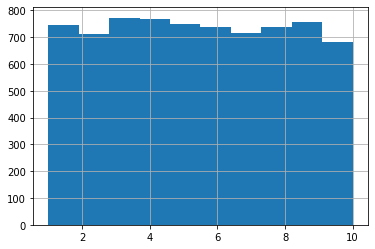

In [10]:
col.dt.month.hist()

Rozkład daty składania zamówień podzielonych na miesiące jest w przybliżeniu jednostajny

#### Kolumna *delivery_timestamp*

In [11]:
deliveries["delivery_timestamp"].dtype

dtype('O')

In [12]:
deliveries["delivery_timestamp"] = pd.to_datetime(deliveries["delivery_timestamp"])
col = deliveries["delivery_timestamp"]

In [13]:
{"min": col.min(), "max": col.max()}

{'min': Timestamp('2021-01-02 08:09:35.963013'),
 'max': Timestamp('2021-10-30 08:44:37.680748')}

Zamówienia były dostarczone między *2021-01-02*, a *2021-10-30*.

<AxesSubplot:>

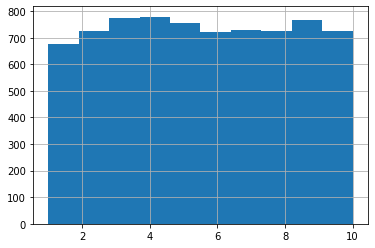

In [14]:
col.dt.month.hist()

Rozkład daty dostarczenia zamówień podzielonych na miesiące jest w przybliżeniu jednostajny

#### Kolumna *delivery_company*

In [15]:
deliveries["delivery_company"].dtype

dtype('int64')

In [16]:
col = deliveries["delivery_company"]

In [17]:
col.unique().tolist()

[620, 360, 516]

Zamowienia dostarczone są przez trzech dostawców

<AxesSubplot:>

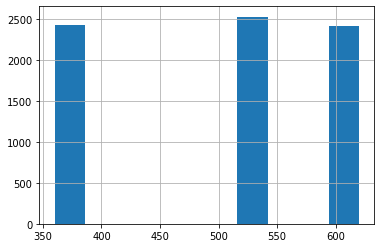

In [18]:
col.hist()

Wykorzystanie dostawców ma rozkład jednostajny

### Czy istnieją wpisy z datą dostawy wcześniejsza niż czas zamówienia?

In [19]:
np.where((deliveries["delivery_timestamp"] < deliveries["purchase_timestamp"]))[0].size

0

Nie występują takie wpisy.

### Czas dostawy

In [20]:
deliveries["time"] = (deliveries["delivery_timestamp"] - deliveries["purchase_timestamp"]) / np.timedelta64(1,'h')

In [21]:
col = deliveries["time"]
col

0       54.442714
1       65.429676
2       58.517116
3       55.222574
4       56.719851
          ...    
7378    77.138135
7379    44.158122
7380    43.149846
7381    18.115892
7382    53.779790
Name: time, Length: 7383, dtype: float64

In [22]:
col.describe()

count    7383.000000
mean       48.001029
std        19.870723
min         4.026916
25%        33.310697
50%        47.209810
75%        61.720920
max       123.546516
Name: time, dtype: float64

Czas dostawy poszczególnych zamówień wydaje się prawidłowy - nie ma zarówno zbyt krótkich jak i zbyt długich.

In [23]:
time_mean = col.mean()
time_std = col.std()

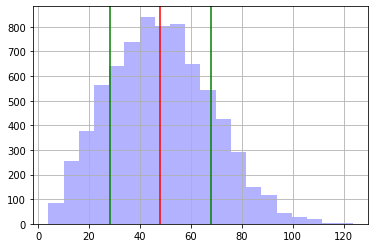

In [24]:
plt.hist(col, bins = 20, facecolor = "blue", alpha = 0.3)
plt.grid()
plt.axvline(x = time_mean, color='r')
plt.axvline(x = time_mean - time_std, color = 'g')
plt.axvline(x = time_mean + time_std, color = 'g')
plt.show()

Czas dostawy prawdopodobnie jest rozkładem normalnym $\sim N(\mu = 48.0, \sigma = 19.8)$

## Tabela users

In [25]:
users = loadData("users.jsonl")

In [26]:
users.count()

user_id    200
name       200
city       200
street     200
dtype: int64

Nie ma żadnych pól o wartości *null*.

In [27]:
users["user_id"].is_unique

True

### Kolumna *name*

In [28]:
nameLen = set()
for row in users["name"]:
    nameLen.add(len(row.split(" ")))

nameLen

{2}

Nie występują klienci o dwóch imionach lub nazwiskach. Zawsze jest to para pierwsze imie i naziwsko.

### Kolumna *street*

In [29]:
streetLen = set()
for row in users["street"]:
    streetLen.add(len(row.split(" ")))

streetLen

{3, 4, 5}

Pole adres składa się z 3, 4 lub 5 słów. Z 1 na przedrostek, 1/2/3 na główny człon oraz 1 na numer.

### Kolumna *city*

In [30]:
col = users["city"]

In [31]:
col.dtype

dtype('O')

In [32]:
col.unique().tolist()

['Kraków', 'Gdynia', 'Poznań', 'Szczecin', 'Radom', 'Warszawa', 'Wrocław']

Przesyłki dostarczane są do 7 różnych miast.

<AxesSubplot:>

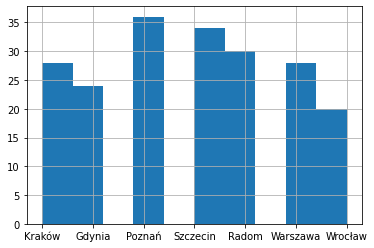

In [33]:
col.hist()

## Tabela *sessions*

In [34]:
sessions = loadData("sessions.jsonl")

In [35]:
sessions.count()

session_id          40068
timestamp           40068
user_id             40068
product_id          40068
event_type          40068
offered_discount    40068
purchase_id          7383
dtype: int64

We żadnej kolumnie poza *purchase_id* nie wystepują wartości puste. *Null* w kolumnie z id zamówienia oznacza, że podczas danej sesji klient nie złożył zamówienia. Z tego powodu nie jest to traktowane jako brak danych.

In [36]:
sessions["session_id"].is_unique

False

Brak unikalności w ID sesji wynika z faktu, że są to prawdopodobnie sesje przeglądarki i w ciągu jednej sesji użytkownik mógł oglądać i kupować różne przedmioty.

### Kolumna *timestamp*

In [37]:
sessions["timestamp"].dtype

dtype('<M8[ns]')

In [38]:
col = sessions["timestamp"]

In [39]:
{"min": col.min(), "max": col.max()}

{'min': Timestamp('2021-01-01 00:45:25'),
 'max': Timestamp('2021-10-27 15:26:48')}

Sesje występowały między *2021-01-01*, a *2021-10-27*.

<AxesSubplot:>

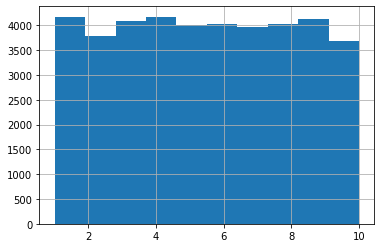

In [40]:
col.dt.month.hist()

Rozkład daty sesji podzielonych na miesiące jest w przybliżeniu jednostajny

### Kolumna *event_type*

In [41]:
col = sessions["event_type"]

In [42]:
col.unique().tolist()

['VIEW_PRODUCT', 'BUY_PRODUCT']

<AxesSubplot:>

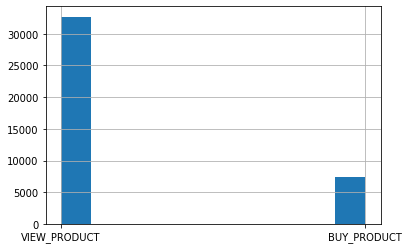

In [43]:
col.hist()

In [44]:
sessions.groupby('event_type').count()["session_id"]

event_type
BUY_PRODUCT      7383
VIEW_PRODUCT    32685
Name: session_id, dtype: int64

### Kolumna *offered_discount*

In [45]:
col = sessions["offered_discount"]

In [46]:
col.unique().tolist()

[0, 10, 5, 20, 15]

<AxesSubplot:>

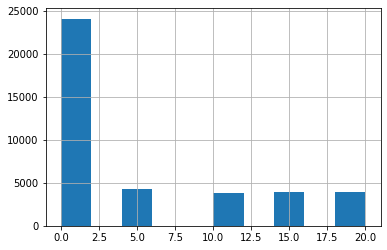

In [47]:
col.hist()

# Tabla *products*

In [48]:
products = loadData("products.jsonl")

In [49]:
products.count()

product_id       319
product_name     319
category_path    319
price            319
dtype: int64

In [50]:
products["product_id"].is_unique

True

In [51]:
products["product_name"].is_unique

True

### Kolumna *product_name*

In [52]:
products["product_name"].unique().size

319

Nazwy przedmiotów nie powtarzają się

### Kolumna *category_path*

In [53]:
categories = set()
for row in products["category_path"]:
    categories.update(row.split(';'))

In [54]:
categories

{'Akcesoria telefoniczne',
 'Anteny RTV',
 'Audio',
 'Biurowe urządzenia wielofunkcyjne',
 'Drukarki i skanery',
 'Gry PlayStation3',
 'Gry Xbox 360',
 'Gry i konsole',
 'Gry komputerowe',
 'Gry na konsole',
 'Komputery',
 'Monitory',
 'Monitory LCD',
 'Odtwarzacze DVD',
 'Odtwarzacze mp3 i mp4',
 'Okulary 3D',
 'Przenośne audio i video',
 'Sprzęt RTV',
 'Słuchawki',
 'Tablety',
 'Tablety i akcesoria',
 'Telefony i akcesoria',
 'Telefony komórkowe',
 'Telefony stacjonarne',
 'Telewizory i akcesoria',
 'Video',
 'Zestawy głośnomówiące',
 'Zestawy słuchawkowe'}

In [55]:
categories_occurence = {}
for category in categories:
    categories_occurence[category] = 0

for row in products["category_path"]:
    for category in row.split(';'):
        categories_occurence[category] += 1

categories_occurence

{'Telefony i akcesoria': 12,
 'Monitory LCD': 17,
 'Gry i konsole': 243,
 'Tablety': 2,
 'Telewizory i akcesoria': 31,
 'Gry PlayStation3': 9,
 'Telefony stacjonarne': 1,
 'Drukarki i skanery': 9,
 'Gry na konsole': 41,
 'Gry Xbox 360': 32,
 'Zestawy głośnomówiące': 5,
 'Słuchawki': 1,
 'Video': 33,
 'Sprzęt RTV': 36,
 'Zestawy słuchawkowe': 4,
 'Odtwarzacze mp3 i mp4': 2,
 'Przenośne audio i video': 2,
 'Anteny RTV': 30,
 'Biurowe urządzenia wielofunkcyjne': 9,
 'Komputery': 28,
 'Monitory': 17,
 'Gry komputerowe': 202,
 'Akcesoria telefoniczne': 9,
 'Audio': 1,
 'Tablety i akcesoria': 2,
 'Telefony komórkowe': 2,
 'Okulary 3D': 1,
 'Odtwarzacze DVD': 2}

### Kolumna *price*

In [56]:
products["price"].describe()

count     319.000000
mean      247.787962
std       813.788548
min         1.000000
25%        24.990000
50%        41.000000
75%        92.995000
max      7639.000000
Name: price, dtype: float64

Ceny ujemne należałoby traktować jako błędne dane, ale w dostarczonym zestawie nie występują

# Analiza połączonych tabel

Jako, że tabela produktów nie przenosi dla nas żadnej potrzebnej informacji to nie zostaje dołączona.

In [57]:
joinedTables = sessions.merge(deliveries, on = "purchase_id", how = "left").merge(users, on = "user_id", how = "left")

In [58]:
joinedTables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40068 entries, 0 to 40067
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   session_id          40068 non-null  int64         
 1   timestamp           40068 non-null  datetime64[ns]
 2   user_id             40068 non-null  int64         
 3   product_id          40068 non-null  int64         
 4   event_type          40068 non-null  object        
 5   offered_discount    40068 non-null  int64         
 6   purchase_id         7383 non-null   float64       
 7   purchase_timestamp  7383 non-null   datetime64[ns]
 8   delivery_timestamp  7383 non-null   datetime64[ns]
 9   delivery_company    7383 non-null   float64       
 10  time                7383 non-null   float64       
 11  name                40068 non-null  object        
 12  city                40068 non-null  object        
 13  street              40068 non-null  object    

## Odrzucenie niepotrzebnych danych

Możemy odrzucić wpisy, w których użytkownik tylko przeglądał produkty

In [59]:
joinedTables = joinedTables[joinedTables["event_type"] == "BUY_PRODUCT"]
joinedTables = joinedTables.reset_index()
joinedTables.shape[0] # ilość wierszy

7383

In [60]:
joinedTables

,index,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time,name,city,street
0,3,124,2021-08-01 04:06:48,102,1054,BUY_PRODUCT,0,20001.0,2021-08-01 04:06:48,2021-08-03 10:33:21.769350,620.0,54.442714,Anastazja Marcińczyk,Kraków,al. Starowiejska 60
1,11,125,2021-09-01 17:03:43,102,1032,BUY_PRODUCT,10,20002.0,2021-09-01 17:03:43,2021-09-04 10:29:29.834053,360.0,65.429676,Anastazja Marcińczyk,Kraków,al. Starowiejska 60
2,13,126,2021-03-26 21:30:24,102,1035,BUY_PRODUCT,0,20003.0,2021-03-26 21:30:24,2021-03-29 08:01:25.618844,620.0,58.517116,Anastazja Marcińczyk,Kraków,al. Starowiejska 60
3,16,128,2021-06-10 05:59:29,102,1076,BUY_PRODUCT,0,20004.0,2021-06-10 05:59:29,2021-06-12 13:12:50.265103,620.0,55.222574,Anastazja Marcińczyk,Kraków,al. Starowiejska 60
4,19,129,2021-01-11 07:03:21,102,1233,BUY_PRODUCT,10,20005.0,2021-01-11 07:03:21,2021-01-13 15:46:32.464349,620.0,56.719851,Anastazja Marcińczyk,Kraków,al. Starowiejska 60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7378,40045,10591,2021-04-09 03:33:34,301,1318,BUY_PRODUCT,0,27379.0,2021-04-09 03:33:34,2021-04-12 08:41:51.284434,360.0,77.138135,Marika Grzela,Wrocław,ulica Warszawska 65
7379,40052,10594,2021-07-25 12:13:57,301,1278,BUY_PRODUCT,0,27380.0,2021-07-25 12:13:57,2021-07-27 08:23:26.240621,360.0,44.158122,Marika Grzela,Wrocław,ulica Warszawska 65
7380,40060,10597,2021-04-22 18:15:02,301,1201,BUY_PRODUCT,0,27381.0,2021-04-22 18:15:02,2021-04-24 13:24:01.447128,360.0,43.149846,Marika Grzela,Wrocław,ulica Warszawska 65
7381,40064,10599,2021-01-31 14:48:48,301,1277,BUY_PRODUCT,0,27382.0,2021-01-31 14:48:48,2021-02-01 08:55:45.211586,620.0,18.115892,Marika Grzela,Wrocław,ulica Warszawska 65


Odrzucić niepotrzebne kolumny, które nie przenoszą informacji o dostawie

In [61]:
joinedTables.drop({"session_id", "timestamp", "user_id", "product_id", "event_type", "offered_discount", "purchase_id", "name"}, axis = 1, inplace=True)
joinedTables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7383 entries, 0 to 7382
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               7383 non-null   int64         
 1   purchase_timestamp  7383 non-null   datetime64[ns]
 2   delivery_timestamp  7383 non-null   datetime64[ns]
 3   delivery_company    7383 non-null   float64       
 4   time                7383 non-null   float64       
 5   city                7383 non-null   object        
 6   street              7383 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 403.9+ KB


## Dodatkowe informacje o czasie dostawy

Ze względu, że dzień złożenia i dostarczenia zamówienia może mieć wpływ na czas dostawy dodajemy nową kolumnę.
Np. złożenie zamówienia w weekend opóźni czas dostawy.

In [62]:
joinedTables["purchase_day_of_week"] = joinedTables["purchase_timestamp"].dt.dayofweek
joinedTables["delivery_day_of_week"] = joinedTables["delivery_timestamp"].dt.dayofweek

In [63]:
joinedTables.groupby("purchase_day_of_week").size()

purchase_day_of_week
0    1059
1    1071
2    1074
3    1013
4    1049
5    1052
6    1065
dtype: int64

In [64]:
joinedTables.groupby("delivery_day_of_week").size()

delivery_day_of_week
0    2091
1    1052
2    1073
3    1089
4    1014
5    1064
dtype: int64

Podobnie z godziną w ciągu dnia.
Np. zamówienia złożone w godzinach wieczornych wysyłane są dopiero następnego dnia

In [65]:
joinedTables["purchase_hour"] = joinedTables["purchase_timestamp"].dt.hour
joinedTables["delivery_hour"] = joinedTables["delivery_timestamp"].dt.hour

In [66]:
joinedTables.groupby("purchase_hour").size()

purchase_hour
0     320
1     348
2     299
3     327
4     318
5     298
6     285
7     296
8     327
9     343
10    317
11    296
12    292
13    298
14    305
15    303
16    309
17    337
18    280
19    292
20    302
21    284
22    306
23    301
dtype: int64

In [67]:
joinedTables.groupby("delivery_hour").size()

delivery_hour
8     4252
9      325
10     308
11     310
12     284
13     326
14     316
15     328
16     290
17     313
18     331
dtype: int64

Średni czas dostawy do poszczególnych miast

In [68]:
joinedTables.groupby("city")["time"].mean()

city
Gdynia      64.343165
Kraków      62.889455
Poznań      34.047246
Radom       33.990261
Szczecin    45.449439
Warszawa    67.388307
Wrocław     36.361044
Name: time, dtype: float64